# Web Scraping PokeAPI Data

In [173]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io
import json
from pathlib import Path
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [174]:
# base url for the PokeAPI website
poke_url = 'https://pokeapi.co/api/v2/pokemon/'

In [175]:
# retrieves Pokemon names
pokemon_name_list = [requests.get(poke_url + str(i+1) + '/').json()['name'] for i in range(0, 1010)]

In [176]:
# retrieves base stats for all Pokemon
base_stats_list = [j['base_stat'] for i in range(0, 1010) for j in requests.get(poke_url + str(i+1)).json()['stats']]

In [177]:
# create empty lists for each base stat
hp_stat = []
attack_stat = []
defense_stat = []
special_attack_stat = []
special_defense_stat = []
speed_stat = []

# put base stat value in appropriate list
for i in range(len(base_stats_list)):
    if i % 6 == 0:
        hp_stat.append(base_stats_list[i])
    elif i % 6 == 1:
        attack_stat.append(base_stats_list[i])
    elif i % 6 == 2:
        defense_stat.append(base_stats_list[i])
    elif i % 6 == 3:
        special_attack_stat.append(base_stats_list[i])
    elif i % 6 == 4:
        special_defense_stat.append(base_stats_list[i])
    else:
        speed_stat.append(base_stats_list[i])

In [178]:
# some Pokemon have one type while others, like Charizard, have two
len(requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'])

2

In [179]:
# see what the types are
requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types']

[{'slot': 1,
  'type': {'name': 'fire', 'url': 'https://pokeapi.co/api/v2/type/10/'}},
 {'slot': 2,
  'type': {'name': 'flying', 'url': 'https://pokeapi.co/api/v2/type/3/'}}]

In [180]:
# pull the specific type
requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'][0]['type']['name']

'fire'

In [181]:
# create lists for type 1 and type 2
type1 = []
type2 = []

# append the type to the appropriate list
for t in range(1010):
    if len(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types']) == 1:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append('')
    else:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][1]['type']['name'])

In [182]:
# create pandas data frame
dictionary = {"Pokemon Name" : pokemon_name_list, "Type 1" : type1, "Type 2" : type2, "hp" : hp_stat, "attack" : attack_stat, "defense" : defense_stat,
             "special attack" : special_attack_stat, "special defense" : special_defense_stat, "speed" : speed_stat}
pokemon_df = pd.DataFrame(dictionary)

In [183]:
# create CSV of pandas data frame
pokemon_df.to_csv('pokemon_type_and_base_stats.csv', index=False)

# Feature Engineering PokeAPI Data

In [ ]:
# create combinations of the sums of different base stats
# pokemon_df_stat_combos = pokemon_df.copy()
# pokemon_df_stat_combos['attack and special attack'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['special attack']
# pokemon_df_stat_combos['defense and special defense'] = pokemon_df_stat_combos['defense'] + pokemon_df_stat_combos['special defense']
# pokemon_df_stat_combos['attack and speed'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['speed']
# pokemon_df_stat_combos['special attack and speed'] = pokemon_df_stat_combos['special attack'] + pokemon_df_stat_combos['speed']
# pokemon_df_stat_combos.drop(['attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [ ]:
# create CSV
# pokemon_df_stat_combos.to_csv('pokemon_type_and_base_stats_combos.csv', index=False)

In [184]:
# create ratios of the different base stats by dividing by "speed"
pokemon_df_stat_ratios = pokemon_df.copy()
pokemon_df_stat_ratios['hp / speed'] = pokemon_df_stat_ratios['hp'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['attack / speed'] = pokemon_df_stat_ratios['attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['defense / speed'] = pokemon_df_stat_ratios['defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special attack / speed'] = pokemon_df_stat_ratios['special attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special defense / speed'] = pokemon_df_stat_ratios['special defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios.drop(['hp', 'attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [185]:
# create CSV
pokemon_df_stat_ratios.to_csv('pokemon_type_and_base_stats_ratios.csv', index=False)

In [190]:
# read in the CSV files
pokemon_df = pd.read_csv('pokemon_type_and_base_stats.csv')
# pokemon_df_combos = pd.read_csv('pokemon_type_and_base_stats_combos.csv')
pokemon_df_ratios = pd.read_csv('pokemon_type_and_base_stats_ratios.csv')

# EDA, Preprocessing, and Feature Engineering Kaggle Dataset

https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080 has some good EDA, some of which I have used as well.

In [191]:
# basic descriptive statistics
pokemon_df_ratios.describe()

,hp / speed,attack / speed,defense / speed,special attack / speed,special defense / speed
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,1.304407,1.388164,1.434708,1.213469,1.336978
std,1.215489,1.072827,1.986898,0.761836,1.885055
min,0.025000,0.100000,0.100000,0.125000,0.245033
25%,0.741123,0.828125,0.717500,0.750000,0.739533
50%,1.000000,1.155870,1.000000,1.015565,1.000000
75%,1.500000,1.600000,1.570362,1.441395,1.454545
max,27.000000,17.000000,46.000000,8.000000,46.000000


In [195]:
# correlation matrix
pokemon_df_ratios.iloc[:, 3:].corr()

,hp / speed,attack / speed,defense / speed,special attack / speed,special defense / speed
hp / speed,1.000000,0.793840,0.478678,0.642369,0.541147
attack / speed,0.793840,1.000000,0.569650,0.623993,0.503936
defense / speed,0.478678,0.569650,1.000000,0.450979,0.924360
special attack / speed,0.642369,0.623993,0.450979,1.000000,0.489025
special defense / speed,0.541147,0.503936,0.924360,0.489025,1.000000


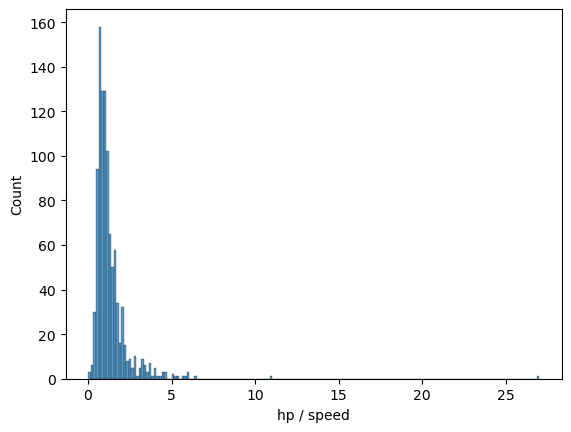

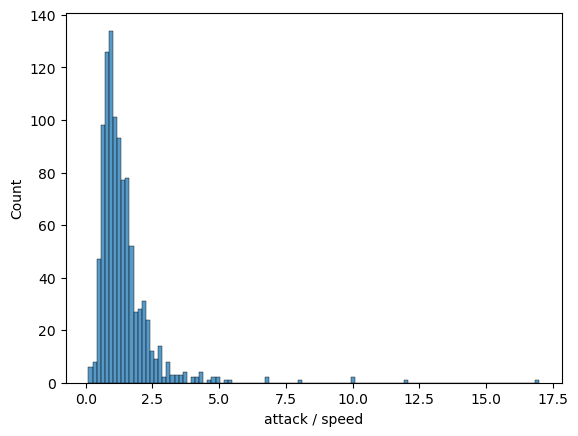

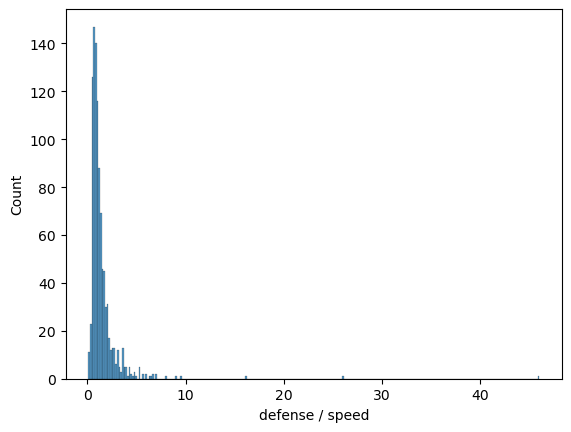

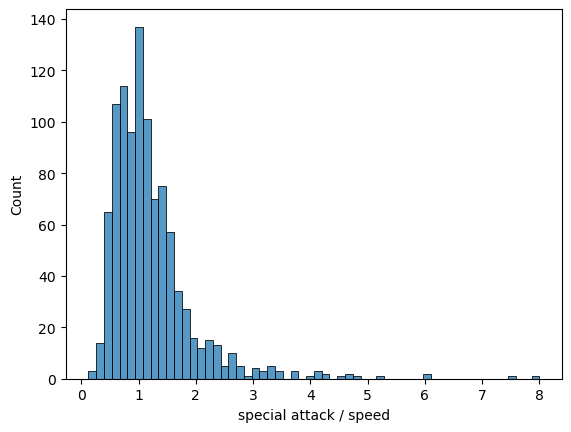

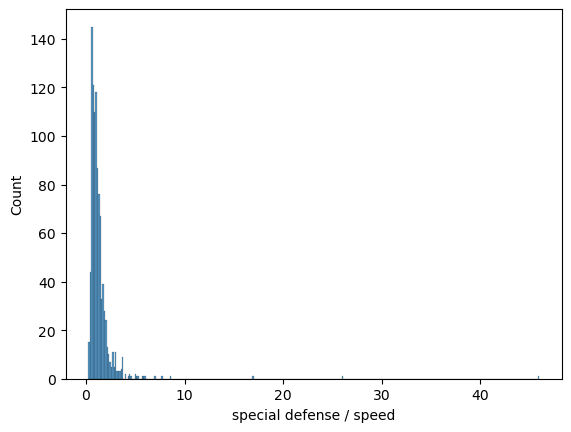

In [196]:
# histograms of distributions for ratios of base stats
sns.histplot(x='hp / speed', data=pokemon_df_ratios)
plt.show()

sns.histplot(x='attack / speed', data=pokemon_df_ratios)
plt.show()

sns.histplot(x='defense / speed', data=pokemon_df_ratios)
plt.show()

sns.histplot(x='special attack / speed', data=pokemon_df_ratios)
plt.show()

sns.histplot(x='special defense / speed', data=pokemon_df_ratios)
plt.show()

In [197]:
# boxplots for ratios of base stats separated by type
sns.boxplot(x='hp / speed', y='Type 1', data=pokemon_df_ratios)
plt.show()

# lots of outliers, but for now, we will not throw them out since a lot of Pokemon would be thrown out
outliers_hp_speed = pd.DataFrame()
for column in pokemon_df_ratios.select_dtypes(include='number').columns:
    Q1 = pokemon_df_ratios[column].quantile(0.25)
    Q3 = pokemon_df_ratios[column].quantile(0.75)
    IQR = Q3 - Q1
    column_outliers = pokemon_df_ratios[(pokemon_df_ratios[column] < (Q1 - 1.5 * IQR)) | (pokemon_df_ratios[column] > (Q3 + 1.5 * IQR))]
    outliers_hp_speed = pd.concat([outliers, column_outliers])

sns.boxplot(x='attack / speed', y='Type 1', data=pokemon_df_ratios)
plt.show()

outliers_ = pd.DataFrame()
for column in pokemon_df_ratios.select_dtypes(include='number').columns:
    Q1 = pokemon_df_ratios[column].quantile(0.25)
    Q3 = pokemon_df_ratios[column].quantile(0.75)
    IQR = Q3 - Q1
    column_outliers = pokemon_df_ratios[(pokemon_df_ratios[column] < (Q1 - 1.5 * IQR)) | (pokemon_df_ratios[column] > (Q3 + 1.5 * IQR))]
    outliers_hp_speed = pd.concat([outliers, column_outliers])

# sns.boxplot(x='defense / speed', y='Type 1', data=pokemon_df_ratios)
# plt.show()

# sns.boxplot(x='special attack / speed', y='Type 1', data=pokemon_df_ratios)
# plt.show()

# sns.boxplot(x='special defense / speed', y='Type 1', data=pokemon_df_ratios)
# plt.show()

,Pokemon Name,Type 1,Type 2,hp / speed,attack / speed,defense / speed,special attack / speed,special defense / speed
38,jigglypuff,normal,fairy,5.750000,2.250000,1.000000,2.250000,1.250000
39,wigglytuff,normal,fairy,3.111111,1.555556,1.000000,1.888889,1.111111
78,slowpoke,water,psychic,6.000000,4.333333,4.333333,2.666667,2.666667
79,slowbro,water,psychic,3.166667,2.500000,3.666667,3.333333,2.666667
87,grimer,poison,NaN,3.200000,3.200000,2.000000,1.600000,2.000000
...,...,...,...,...,...,...,...,...
895,glastrier,ice,NaN,3.333333,4.833333,4.333333,2.166667,3.666667
929,arboliva,grass,normal,2.000000,1.769231,2.307692,3.205128,2.794872
933,garganacl,rock,NaN,2.857143,2.857143,3.714286,1.285714,2.571429
979,clodsire,poison,ground,6.500000,3.750000,3.000000,2.250000,5.000000


In [198]:
# create path object to get into the images directory
path1 = Path('images/images')

# create a list of the file paths that end in .png
files_paths = list(path1.glob('*.png'))

# list comprehension that gets the second element of each tuple of the split path ([pokemon_name].png)
names = [os.path.split(x)[1] for x in files_paths]

# concatenate names list and files_paths list
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files_paths, name='Filepath').astype(str)], axis=1)

# regex matches the file extension
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

,Name,Filepath
0,abomasnow,images\images\abomasnow.png
1,abra,images\images\abra.png
2,absol,images\images\absol.png
3,accelgor,images\images\accelgor.png
4,aegislash-blade,images\images\aegislash-blade.png


In [199]:
# read in pokemon.csv
pokemon = pd.read_csv('pokemon.csv')

# merge image_df and pokemon data frames on the "Name" column
df = image_df.merge(pokemon, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1) 
df.head()

,Filepath,Type1
0,images\images\abomasnow.png,Grass
1,images\images\abra.png,Psychic
2,images\images\absol.png,Dark
3,images\images\accelgor.png,Bug
4,images\images\aegislash-blade.png,Steel


In [200]:
import seaborn as sns

# assigns colors to the different types for visualizations
custom_colors = {
    'Normal': 'gray',
    'Fire': 'orange',
    'Water': 'blue',
    'Grass': 'green',
    'Fairy': 'pink',
    'Fighting': 'red',
    'Dark': 'black',
    'Flying': 'turquoise', 
    'Ghost': 'purple',
    'Electric': 'yellow',
    'Ground': 'brown',
    'Ice': 'white',
    'Bug': '#003008',
    'Poison': 'magenta',
    'Psychic': 'lavender',
    'Rock': 'burlywood',
    'Steel': 'silver',
    'Dragon': 'indigo'
}

In [201]:
# make a list of the types
types = list(custom_colors.keys())

# loop through the types and count the number of values that match the type name
type_nums = []
for type_ in types:
    type_nums.append(sum(df['Type1']==type_))

# create data frame and sort in descending order by Count
data = {'Count': type_nums}
data_df = pd.DataFrame(data, index=types).sort_values(by='Count', ascending=False)

# get the types
types = data_df.index.to_list()

# rearrange the colors to match key order with "types" order
rearranged_colors = {key: custom_colors[key] for key in types}

# get color palette
sns.set_palette(sns.color_palette(rearranged_colors.values()))

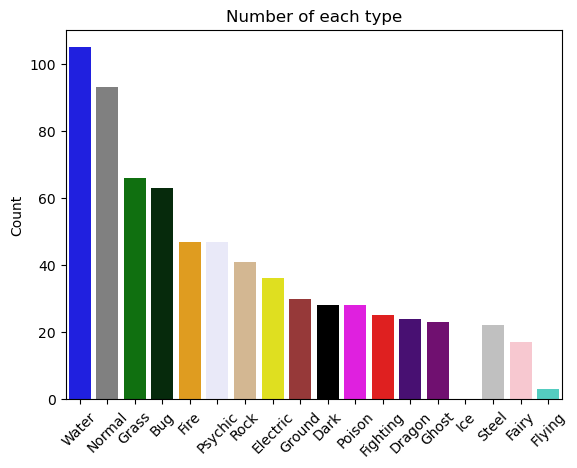

In [202]:
# create barplot of the count of each type in descending order
plt.title('Number of each type')
ax = sns.barplot(x=data_df.index, y='Count', data=data_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

# CNN with Kaggle Dataset

In [18]:
X_train, X_test = train_test_split(df, test_size=.2, random_state=42)

In [19]:
# create image generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# create training set
train_data = datagen.flow_from_dataframe(
    X_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

# create validation set
val_data = datagen.flow_from_dataframe(
    X_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

# create test set
test_data = datagen.flow_from_dataframe(
    X_test,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
)

Found 461 validated image filenames belonging to 18 classes.
Found 115 validated image filenames belonging to 18 classes.
Found 145 validated image filenames belonging to 18 classes.


In [20]:
# create the CNN model
# pretty bad when trying to do all 18 types
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
15/15 [==============================] - 18s 1s/step - loss: 2.8452 - accuracy: 0.1258 - val_loss: 2.7257 - val_accuracy: 0.1391
Epoch 2/10
15/15 [==============================] - 10s 666ms/step - loss: 2.4976 - accuracy: 0.2560 - val_loss: 2.9355 - val_accuracy: 0.1043
Epoch 3/10
15/15 [==============================] - 9s 579ms/step - loss: 2.0594 - accuracy: 0.3688 - val_loss: 2.7802 - val_accuracy: 0.1652
Epoch 4/10
15/15 [==============================] - 9s 624ms/step - loss: 1.2670 - accuracy: 0.6291 - val_loss: 3.7382 - val_accuracy: 0.1130
Epoch 5/10
15/15 [==============================] - 10s 660ms/step - loss: 0.6104 - accuracy: 0.8200 - val_loss: 4.9922 - val_accuracy: 0.0783
Epoch 6/10
15/15 [==============================] - 10s 635ms/step - loss: 0.2197 - accuracy: 0.9371 - val_loss: 5.9272 - val_accuracy: 0.0783
Epoch 7/10
15/15 [==============================] - 10s 657ms/step - loss: 0.1250 - accuracy: 0.9631 - val_loss: 7.1301 - val_accuracy: 0.1130
Epoc

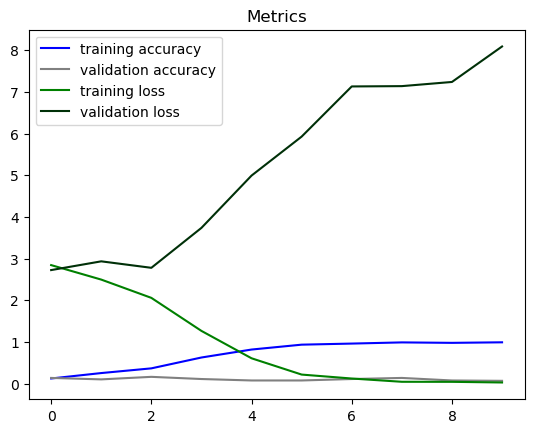

In [21]:
# plot the training and validation accuracies and the training and validation losses
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

plt.plot(epochs, accuracy, label='training accuracy')
plt.plot(epochs, val_accuracy, label='validation accuracy')
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [22]:
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print('Testing accuracy:', test_accuracy)

5/5 [==============================] - 2s 331ms/step - loss: 7.5698 - accuracy: 0.1448
Testing accuracy: 0.14482758939266205


In [23]:
# now filter the data to just Pokemon that are either of two types for predictions
binary_df_train = X_train.query("Type1 == 'Bug' | Type1 == 'Fire'")
binary_df_test = X_test.query("Type1 == 'Bug' | Type1 == 'Fire'")

# create training set
train_data2 = datagen.flow_from_dataframe(
    binary_df_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

# create validation set
val_data2 = datagen.flow_from_dataframe(
    binary_df_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

test_data2 = datagen.flow_from_dataframe(
    binary_df_test,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32
)

cnn_model2 = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history2 = cnn_model2.fit(train_data2, validation_data=val_data2, epochs=10)

Found 66 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 4s 650ms/step - loss: 2.1301 - accuracy: 0.3939 - val_loss: 1.2995 - val_accuracy: 0.3750
Epoch 2/10
3/3 [==============================] - 2s 549ms/step - loss: 0.8361 - accuracy: 0.4545 - val_loss: 0.6841 - val_accuracy: 0.6250
Epoch 3/10
3/3 [==============================] - 2s 794ms/step - loss: 0.6991 - accuracy: 0.5606 - val_loss: 0.6831 - val_accuracy: 0.6250
Epoch 4/10
3/3 [==============================] - 2s 603ms/step - loss: 0.6750 - accuracy: 0.5606 - val_loss: 0.6534 - val_accuracy: 0.6250
Epoch 5/10
3/3 [==============================] - 2s 552ms/step - loss: 0.6300 - accuracy: 0.5606 - val_loss: 0.6303 - val_accuracy: 0.6875
Epoch 6/10
3/3 [==============================] - 2s 611ms/step - loss: 0.5836 - accuracy: 0.6818 - val_loss: 0.5867 - val_

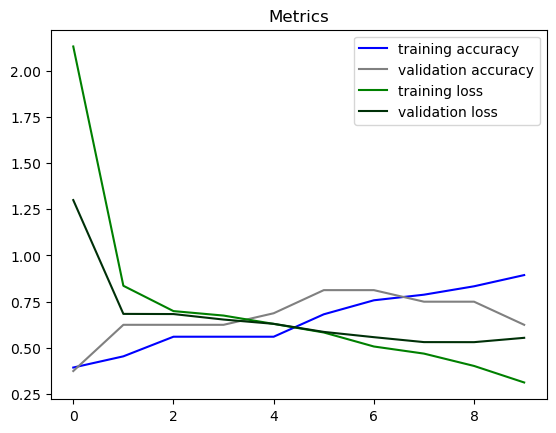

In [24]:
# plot the training and validation accuracies and the training and validation losses
loss2 = history2.history['loss']
accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']
epochs2 = range(len(loss2))

plt.plot(epochs2, accuracy2, label='training accuracy')
plt.plot(epochs2, val_accuracy2, label='validation accuracy')
plt.plot(epochs2, loss2, label='training loss')
plt.plot(epochs2, val_loss2, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [25]:
binary_test_loss, binary_test_accuracy = cnn_model2.evaluate(test_data2)
print('Testing accuracy:', binary_test_accuracy)

1/1 [==============================] - 0s 155ms/step - loss: 0.6377 - accuracy: 0.7143
Testing accuracy: 0.7142857313156128


# FFN with Kaggle Dataset

In [26]:
ffn_model = Sequential([
    Flatten(input_shape=(150, 150, 4)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

ffn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

ffn_history = ffn_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
15/15 [==============================] - 11s 589ms/step - loss: 12.0300 - accuracy: 0.0889 - val_loss: 10.2801 - val_accuracy: 0.1043
Epoch 2/10
15/15 [==============================] - 8s 505ms/step - loss: 4.1083 - accuracy: 0.2408 - val_loss: 4.9238 - val_accuracy: 0.0696
Epoch 3/10
15/15 [==============================] - 21s 1s/step - loss: 2.6360 - accuracy: 0.3384 - val_loss: 3.4843 - val_accuracy: 0.1217
Epoch 4/10
15/15 [==============================] - 9s 579ms/step - loss: 1.5949 - accuracy: 0.4772 - val_loss: 3.4506 - val_accuracy: 0.1391
Epoch 5/10
15/15 [==============================] - 8s 521ms/step - loss: 1.2121 - accuracy: 0.6529 - val_loss: 3.5882 - val_accuracy: 0.1217
Epoch 6/10
15/15 [==============================] - 7s 492ms/step - loss: 0.8813 - accuracy: 0.7636 - val_loss: 3.5406 - val_accuracy: 0.1739
Epoch 7/10
15/15 [==============================] - 7s 469ms/step - loss: 0.6546 - accuracy: 0.8503 - val_loss: 3.6247 - val_accuracy: 0.1391
Epoch

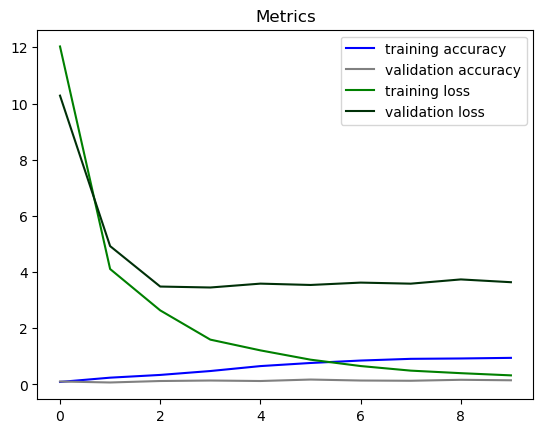

In [27]:
ffn_loss = ffn_history.history['loss']
ffn_accuracy = ffn_history.history['accuracy']
ffn_val_loss = ffn_history.history['val_loss']
ffn_val_accuracy = ffn_history.history['val_accuracy']
ffn_epochs = range(len(loss))

plt.plot(ffn_epochs, ffn_accuracy, label='training accuracy')
plt.plot(ffn_epochs, ffn_val_accuracy, label='validation accuracy')
plt.plot(ffn_epochs, ffn_loss, label='training loss')
plt.plot(ffn_epochs, ffn_val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [28]:
ffn_test_loss, ffn_test_accuracy = ffn_model.evaluate(test_data)
print('Testing accuracy:', ffn_test_accuracy)

5/5 [==============================] - 0s 55ms/step - loss: 3.7110 - accuracy: 0.2069
Testing accuracy: 0.2068965584039688


In [29]:
ffn_model2 = Sequential([
    Flatten(input_shape=(150, 150, 4)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

ffn_model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

ffn_history2 = ffn_model2.fit(train_data2, validation_data=val_data2, epochs=10)

Epoch 1/10
3/3 [==============================] - 3s 823ms/step - loss: 8.3539 - accuracy: 0.4697 - val_loss: 13.6507 - val_accuracy: 0.6250
Epoch 2/10
3/3 [==============================] - 2s 532ms/step - loss: 10.5272 - accuracy: 0.5606 - val_loss: 8.4600 - val_accuracy: 0.3750
Epoch 3/10
3/3 [==============================] - 2s 503ms/step - loss: 4.1080 - accuracy: 0.6515 - val_loss: 10.2568 - val_accuracy: 0.6250
Epoch 4/10
3/3 [==============================] - 1s 482ms/step - loss: 8.7133 - accuracy: 0.5909 - val_loss: 6.7416 - val_accuracy: 0.6875
Epoch 5/10
3/3 [==============================] - 1s 472ms/step - loss: 3.0427 - accuracy: 0.7121 - val_loss: 6.3154 - val_accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 1s 475ms/step - loss: 4.0127 - accuracy: 0.6970 - val_loss: 7.7765 - val_accuracy: 0.5625
Epoch 7/10
3/3 [==============================] - 1s 475ms/step - loss: 3.6869 - accuracy: 0.6515 - val_loss: 3.4796 - val_accuracy: 0.6250
Epoch 8/10
3/3 [=

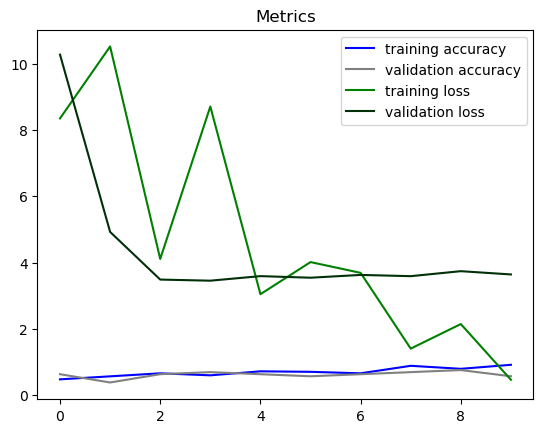

In [30]:
ffn_loss2 = ffn_history2.history['loss']
ffn_accuracy2 = ffn_history2.history['accuracy']
ffn_val_loss2 = ffn_history2.history['val_loss']
ffn_val_accuracy2 = ffn_history2.history['val_accuracy']
ffn_epochs2 = range(len(loss))

plt.plot(ffn_epochs2, ffn_accuracy2, label='training accuracy')
plt.plot(ffn_epochs2, ffn_val_accuracy2, label='validation accuracy')
plt.plot(ffn_epochs2, ffn_loss2, label='training loss')
plt.plot(ffn_epochs2, ffn_val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [31]:
ffn_binary_test_loss, ffn_binary_test_accuracy = ffn_model2.evaluate(test_data2)
print('Testing accuracy:', ffn_binary_test_accuracy)

1/1 [==============================] - 0s 138ms/step - loss: 4.3334 - accuracy: 0.6786
Testing accuracy: 0.6785714030265808


# KNN with PokeAPI Dataset

In [7]:
# split the data into training and testing sets
X_ratio = pokemon_df_ratios.drop('Type 1', axis=1)
y_ratio = pokemon_df_ratios['Type 1']

X_train_ratio, X_test_ratio, y_train_ratio, y_test_ratio = train_test_split(X_ratio, y_ratio, test_size=.2, random_state=42)

In [67]:
# also split the data for binary cases
X_ratio_binary = pokemon_df_ratios.query("`Type 1` == 'bug' or `Type 1` == 'fire'").drop('Type 1', axis=1)
y_ratio_binary = pokemon_df_ratios.query("`Type 1` == 'bug' or `Type 1` == 'fire'")['Type 1']

X_train_ratio_binary, X_test_ratio_binary, y_train_ratio_binary, y_test_ratio_binary = train_test_split(X_ratio_binary, y_ratio_binary, test_size=.2, random_state=42)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# create and fit KNN model
knn_ratio_df = KNeighborsClassifier()
knn_ratio_df.fit(X_train_ratio, y_train_ratio)

KNeighborsClassifier()

In [27]:
# get accuracy, precision, and recall scores
yhat_train_knn = knn_ratio_df.predict(X_train_ratio)
yhat_test_knn = knn_ratio_df.predict(X_test_ratio)
print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_knn))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_knn))

print('Training precision:', precision_score(y_train_ratio, yhat_train_knn, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_knn, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_knn, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_knn, average='macro'))

Training accuracy: 0.46905940594059403
Testing accuracy: 0.22772277227722773
Training precision: 0.5043572889488037
Testing precision: 0.26518549428111804
Training recall: 0.4366251267534418
Testing recall: 0.20553506353944953


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
# create and fit KNN model for binary classification
knn_ratio_df_binary = KNeighborsClassifier()
knn_ratio_df_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

KNeighborsClassifier()

In [126]:
# get accuracy, precision, and recall scores
yhat_train_knn_binary = knn_ratio_df_binary.predict(X_train_ratio_binary)
yhat_test_knn_binary = knn_ratio_df_binary.predict(X_test_ratio_binary)
print('Training accuracy:', accuracy_score(y_train_ratio_binary, yhat_train_knn_binary))
print('Testing accuracy:', accuracy_score(y_test_ratio_binary, yhat_test_knn_binary))

print('Training precision:', precision_score(y_train_ratio_binary, yhat_train_knn_binary, average='macro'))
print('Testing precision:', precision_score(y_test_ratio_binary, yhat_test_knn_binary, average='macro'))

print('Training recall:', recall_score(y_train_ratio_binary, yhat_train_knn_binary, average='macro'))
print('Testing recall:', recall_score(y_test_ratio_binary, yhat_test_knn_binary, average='macro'))

Training accuracy: 0.7966101694915254
Testing accuracy: 0.8
Training precision: 0.8176328502415459
Testing precision: 0.8
Training recall: 0.8029953917050692
Testing recall: 0.8571428571428572


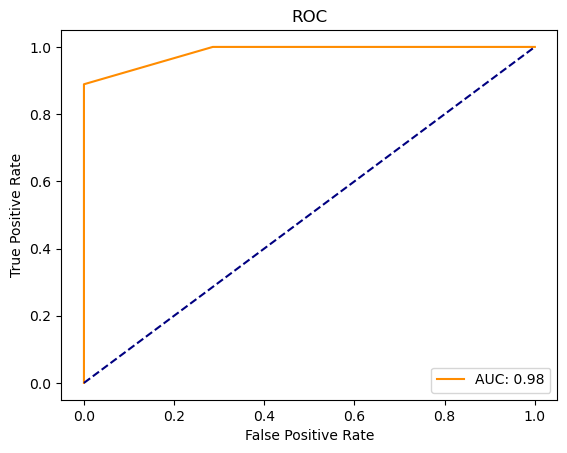

In [127]:
from sklearn.metrics import roc_curve, auc

y_prob_test_knn_binary = knn_ratio_df_binary.predict_proba(X_test_ratio_binary)[:, 1]

y_test_dummies_knn_binary = pd.get_dummies(y_test_ratio_binary, drop_first=True)

# ROC and AUC
false_pos_rate_knn_binary, true_pos_rate_knn_binary, other = roc_curve(y_test_dummies_knn_binary, y_prob_test_knn_binary)
roc_auc = auc(false_pos_rate_knn_binary, true_pos_rate_knn_binary)

# plot ROC
plt.plot(false_pos_rate_knn_binary, true_pos_rate_knn_binary, color='darkorange', label='AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Decision Trees with PokeAPI Dataset

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# create and fit a decision tree model
dt_ratio_df = DecisionTreeClassifier()
dt_ratio_df.fit(X_train_ratio, y_train_ratio)

In [ ]:
# get accuracy, precision, and recall scores
yhat_train_dt = dt_ratio_df.predict(X_train_ratio)
yhat_test_dt = dt_ratio_df.predict(X_test_ratio)
print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_dt))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_dt))

print('Training precision:', precision_score(y_train_ratio, yhat_train_dt, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_dt, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_dt, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_dt, average='macro'))

In [30]:
from sklearn.tree import DecisionTreeClassifier

# binary classification
# create and fit a decision tree model
dt_ratio_df_binary = DecisionTreeClassifier()
dt_ratio_df_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

DecisionTreeClassifier()

In [31]:
# get accuracy, precision, and recall scores
yhat_train_dt_binary = dt_ratio_df_binary.predict(X_train_ratio_binary)
yhat_test_dt_binary = dt_ratio_df_binary.predict(X_test_ratio_binary)
print('Training accuracy:', accuracy_score(y_train_ratio_binary, yhat_train_dt_binary))
print('Testing accuracy:', accuracy_score(y_test_ratio_binary, yhat_test_dt_binary))

print('Training precision:', precision_score(y_train_ratio_binary, yhat_train_dt_binary, average='macro'))
print('Testing precision:', precision_score(y_test_ratio_binary, yhat_test_dt_binary, average='macro'))

print('Training recall:', recall_score(y_train_ratio_binary, yhat_train_dt_binary, average='macro'))
print('Testing recall:', recall_score(y_test_ratio_binary, yhat_test_dt_binary, average='macro'))

Training accuracy: 1.0
Testing accuracy: 0.7
Training precision: 1.0
Testing precision: 0.7142857142857143
Training recall: 1.0
Testing recall: 0.753968253968254


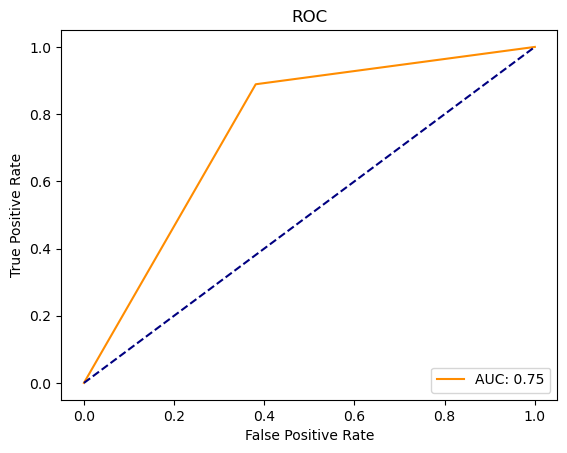

In [94]:
from sklearn.metrics import roc_curve, auc

y_prob_test_dt_binary = dt_ratio_df_binary.predict_proba(X_test_ratio_binary)[:, 1]

y_test_dummies_dt_binary = pd.get_dummies(y_test_ratio_binary, drop_first=True)

# ROC and AUC
false_pos_rate_dt_binary, true_pos_rate_dt_binary, other = roc_curve(y_test_dummies_dt_binary, y_prob_test_dt_binary)
roc_auc = auc(false_pos_rate_dt_binary, true_pos_rate_dt_binary)

# plot ROC
plt.plot(false_pos_rate_dt_binary, true_pos_rate_dt_binary, color='darkorange', label='AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Random Forests with PokeAPI Dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# create a pipeline
rf_pipeline = Pipeline([
    ('random_forest', RandomForestClassifier())
])

# assign different values to tuning parameters
rf_params = {'random_forest__max_depth': [i for i in range(5, 16)],
         'random_forest__n_estimators': [i for i in range(60, 161, 20)],
         'random_forest__criterion': ['gini', 'entropy', 'log_loss'],
         'random_forest__max_features': ['sqrt', 'log2']}

# do a grid search and fit the model
grid_search = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=10)
grid_search.fit(X_train_ratio, y_train_ratio)

In [ ]:
# get the best parameters
grid_search.best_params_

In [ ]:
# create a model with the best parameter values
best_params_rf = RandomForestClassifier(max_depth=7, criterion='entropy', max_features='log2', n_estimators=60)
best_params_rf.fit(X_train_ratio, y_train_ratio)

In [ ]:
# get accuracy, precision, and recall scores
yhat_train_rf = rf_best_params_pipeline.predict(X_train_ratio)
yhat_test_rf = rf_best_params_pipeline.predict(X_test_ratio)

print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_rf))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_rf))

print('Training precision:', precision_score(y_train_ratio, yhat_train_rf, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_rf, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_rf, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_rf, average='macro'))

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# binary classification
# create a pipeline
rf_pipeline_binary = Pipeline([
    ('random_forest', RandomForestClassifier())
])

# assign different values to tuning parameters
rf_params_binary = {'random_forest__max_depth': [i for i in range(5, 16)],
         'random_forest__n_estimators': [i for i in range(60, 161, 20)],
         'random_forest__criterion': ['gini', 'entropy', 'log_loss'],
         'random_forest__max_features': ['sqrt', 'log2']}

# do a grid search and fit the model
grid_search_binary = GridSearchCV(rf_pipeline_binary, param_grid=rf_params_binary, cv=10)
grid_search_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'random_forest__criterion': ['gini', 'entropy',
                                                      'log_loss'],
                         'random_forest__max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15],
                         'random_forest__max_features': ['sqrt', 'log2'],
                         'random_forest__n_estimators': [60, 80, 100, 120, 140,
                                                         160]})

In [79]:
# get the best parameters
grid_search_binary.best_params_

{'random_forest__criterion': 'entropy',
 'random_forest__max_depth': 14,
 'random_forest__max_features': 'log2',
 'random_forest__n_estimators': 80}

In [83]:
# create a model with the best parameter values
best_params_rf_binary = RandomForestClassifier(max_depth=14, criterion='entropy', max_features='log2', n_estimators=80)
best_params_rf_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features='log2',
                       n_estimators=80)

In [84]:
# get accuracy, precision, and recall scores
yhat_train_rf_binary = best_params_rf_binary.predict(X_train_ratio_binary)
yhat_test_rf_binary = best_params_rf_binary.predict(X_test_ratio_binary)

print('Training accuracy:', accuracy_score(y_train_ratio_binary, yhat_train_rf_binary))
print('Testing accuracy:', accuracy_score(y_test_ratio_binary, yhat_test_rf_binary))

print('Training precision:', precision_score(y_train_ratio_binary, yhat_train_rf_binary, average='macro'))
print('Testing precision:', precision_score(y_test_ratio_binary, yhat_test_rf_binary, average='macro'))

print('Training recall:', recall_score(y_train_ratio_binary, yhat_train_rf_binary, average='macro'))
print('Testing recall:', recall_score(y_test_ratio_binary, yhat_test_rf_binary, average='macro'))

Training accuracy: 1.0
Testing accuracy: 0.8
Training precision: 1.0
Testing precision: 0.8
Training recall: 1.0
Testing recall: 0.8571428571428572


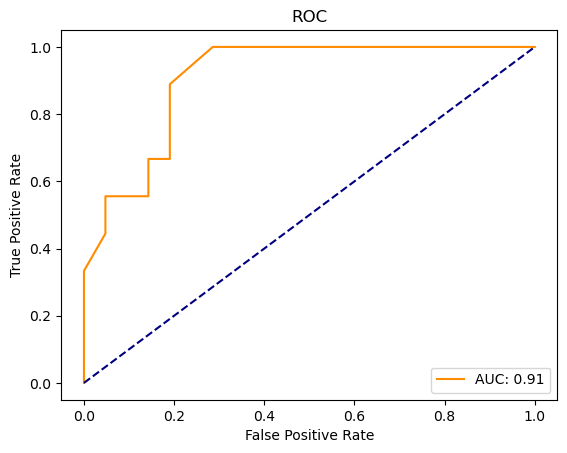

In [95]:
from sklearn.metrics import roc_curve, auc

y_prob_test_rf_binary = best_params_rf_binary.predict_proba(X_test_ratio_binary)[:, 1]

y_test_dummies_rf_binary = pd.get_dummies(y_test_ratio_binary, drop_first=True)

# ROC and AUC
false_pos_rate_rf_binary, true_pos_rate_rf_binary, other = roc_curve(y_test_dummies_rf_binary, y_prob_test_rf_binary)
roc_auc = auc(false_pos_rate_rf_binary, true_pos_rate_rf_binary)

# plot ROC
plt.plot(false_pos_rate_rf_binary, true_pos_rate_rf_binary, color='darkorange', label='AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Ensemble Model with KNN, Decision Trees, and Random Forests with PokeAPI Dataset

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble
ensemble = VotingClassifier(estimators=[
    ('knn', knn_ratio_df),
    ('dt', dt_ratio_df),
    ('random_forest', best_params_rf)
], voting='hard')

# assign different values to tuning parameters
param_grid = {'knn__n_neighbors': [3, 5, 7, 10],
             'dt__max_depth': [3, 5, 7, 10],
             'random_forest__n_estimators': [50, 60, 70, 80, 90, 100],
             'random_forest__max_depth': [3, 5, 7, 10]}

# do a grid search and fit the model
ensemble_grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5)
ensemble_grid_search.fit(X_train_ratio, y_train_ratio)

In [ ]:
# get the best parameters
ensemble_grid_search.best_params_

In [ ]:
# create a model with the best parameter values
ensemble_best_params = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('random_forest', RandomForestClassifier(max_depth=7, n_estimators=90))
])

ensemble_best_params.fit(X_train_ratio, y_train_ratio)

In [ ]:
# Predict using the ensemble
yhat_train_ensemble = ensemble_best_params.predict(X_train_ratio)
yhat_test_ensemble = ensemble_best_params.predict(X_test_ratio)

print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_ensemble))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_ensemble))

print('Training precision:', precision_score(y_train_ratio, yhat_train_ensemble, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_ensemble, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_ensemble, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_ensemble, average='macro'))

In [114]:
from sklearn.ensemble import VotingClassifier

# binary classification
# Create the ensemble
ensemble_binary = VotingClassifier(estimators=[
    ('knn', knn_ratio_df_binary),
    ('dt', dt_ratio_df_binary),
    ('random_forest', best_params_rf_binary)
], voting='hard')

# assign different values to tuning parameters
param_grid_binary = {'knn__n_neighbors': [3, 5, 7, 10],
             'dt__max_depth': [3, 5, 7, 10],
             'random_forest__n_estimators': [50, 60, 70, 80, 90, 100],
             'random_forest__max_depth': [3, 5, 7, 10]}

# do a grid search and fit the model
ensemble_grid_search_binary = GridSearchCV(estimator=ensemble_binary, param_grid=param_grid_binary, cv=5)
ensemble_grid_search_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('knn',
                                                     KNeighborsClassifier(n_neighbors=2)),
                                                    ('dt',
                                                     DecisionTreeClassifier()),
                                                    ('random_forest',
                                                     RandomForestClassifier(criterion='entropy',
                                                                            max_depth=14,
                                                                            max_features='log2',
                                                                            n_estimators=80))]),
             param_grid={'dt__max_depth': [3, 5, 7, 10],
                         'knn__n_neighbors': [3, 5, 7, 10],
                         'random_forest__max_depth': [3, 5, 7, 10],
                         'random_forest__n_estimators': [50, 60, 70, 80, 90,
                                                         100]})

In [115]:
# get the best parameters
ensemble_grid_search_binary.best_params_

{'dt__max_depth': 7,
 'knn__n_neighbors': 10,
 'random_forest__max_depth': 7,
 'random_forest__n_estimators': 50}

In [116]:
# create a model with the best parameter values
ensemble_best_params_binary = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=2)),
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('random_forest', RandomForestClassifier(max_depth=7, n_estimators=90))
],
                                              voting='soft')

ensemble_best_params_binary.fit(X_train_ratio_binary, y_train_ratio_binary)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=2)),
                             ('dt', DecisionTreeClassifier(max_depth=3)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=90))],
                 voting='soft')

In [117]:
# Predict using the ensemble
yhat_train_ensemble_binary = ensemble_best_params_binary.predict(X_train_ratio_binary)
yhat_test_ensemble_binary = ensemble_best_params_binary.predict(X_test_ratio_binary)

print('Training accuracy:', accuracy_score(y_train_ratio_binary, yhat_train_ensemble_binary))
print('Testing accuracy:', accuracy_score(y_test_ratio_binary, yhat_test_ensemble_binary))

print('Training precision:', precision_score(y_train_ratio_binary, yhat_train_ensemble_binary, average='macro'))
print('Testing precision:', precision_score(y_test_ratio_binary, yhat_test_ensemble_binary, average='macro'))

print('Training recall:', recall_score(y_train_ratio_binary, yhat_train_ensemble_binary, average='macro'))
print('Testing recall:', recall_score(y_test_ratio_binary, yhat_test_ensemble_binary, average='macro'))

Training accuracy: 0.9576271186440678
Testing accuracy: 0.7333333333333333
Training precision: 0.959016393442623
Testing precision: 0.7647058823529411
Training recall: 0.9596774193548387
Testing recall: 0.8095238095238095


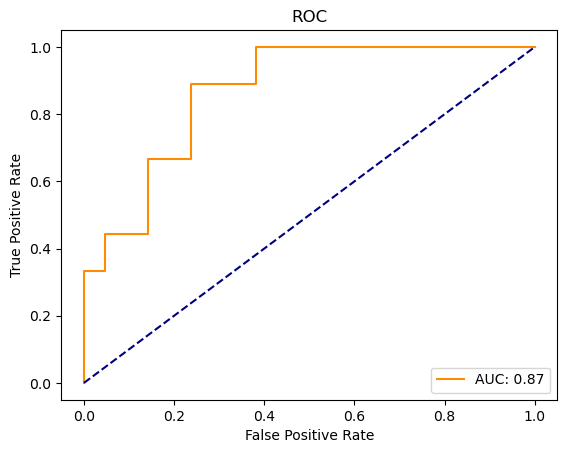

In [118]:
from sklearn.metrics import roc_curve, auc

y_prob_test_ensemble_binary = ensemble_best_params_binary.predict_proba(X_test_ratio_binary)[:, 1]

y_test_dummies_ensemble_binary = pd.get_dummies(y_test_ratio_binary, drop_first=True)

# ROC and AUC
false_pos_rate_ensemble_binary, true_pos_rate_ensemble_binary, other = roc_curve(y_test_dummies_ensemble_binary, y_prob_test_ensemble_binary)
roc_auc = auc(false_pos_rate_ensemble_binary, true_pos_rate_ensemble_binary)

# plot ROC
plt.plot(false_pos_rate_ensemble_binary, true_pos_rate_ensemble_binary, color='darkorange', label='AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# K-Means Clustering

In [36]:
from sklearn.cluster import KMeans

kmeans_ratio_df = KMeans(n_clusters=18, n_init=10)
kmeans_ratio_df.fit(X_train_ratio)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=18, n_init=10)

In [37]:
from sklearn.metrics import silhouette_score

yhat_train_kmeans = kmeans_ratio_df.predict(X_train_ratio)
yhat_test_kmeans = kmeans_ratio_df.predict(X_test_ratio)
print('Training silhouette score:', silhouette_score(X_train_ratio, yhat_train_kmeans))
print('Testing silhouette score:', silhouette_score(X_test_ratio, yhat_test_kmeans))

Training silhouette score: 0.20559296078491007
Testing silhouette score: 0.14649553871290644


In [76]:
from sklearn.cluster import KMeans

# had to use k=3 since the testing labels had values for only one cluster when k=2
kmeans_ratio_df_binary = KMeans(n_clusters=3, n_init=10)
kmeans_ratio_df_binary.fit(X_train_ratio_binary)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init=10)

In [77]:
from sklearn.metrics import silhouette_score

yhat_train_kmeans_binary = kmeans_ratio_df_binary.predict(X_train_ratio_binary)
yhat_test_kmeans_binary = kmeans_ratio_df_binary.predict(X_test_ratio_binary)
print('Training silhouette score:', silhouette_score(X_train_ratio_binary, yhat_train_kmeans_binary))
print('Testing silhouette score:', silhouette_score(X_test_ratio_binary, yhat_test_kmeans_binary))

Training silhouette score: 0.6346392800832599
Testing silhouette score: 0.5559137959138698


# Dimension Reduction?